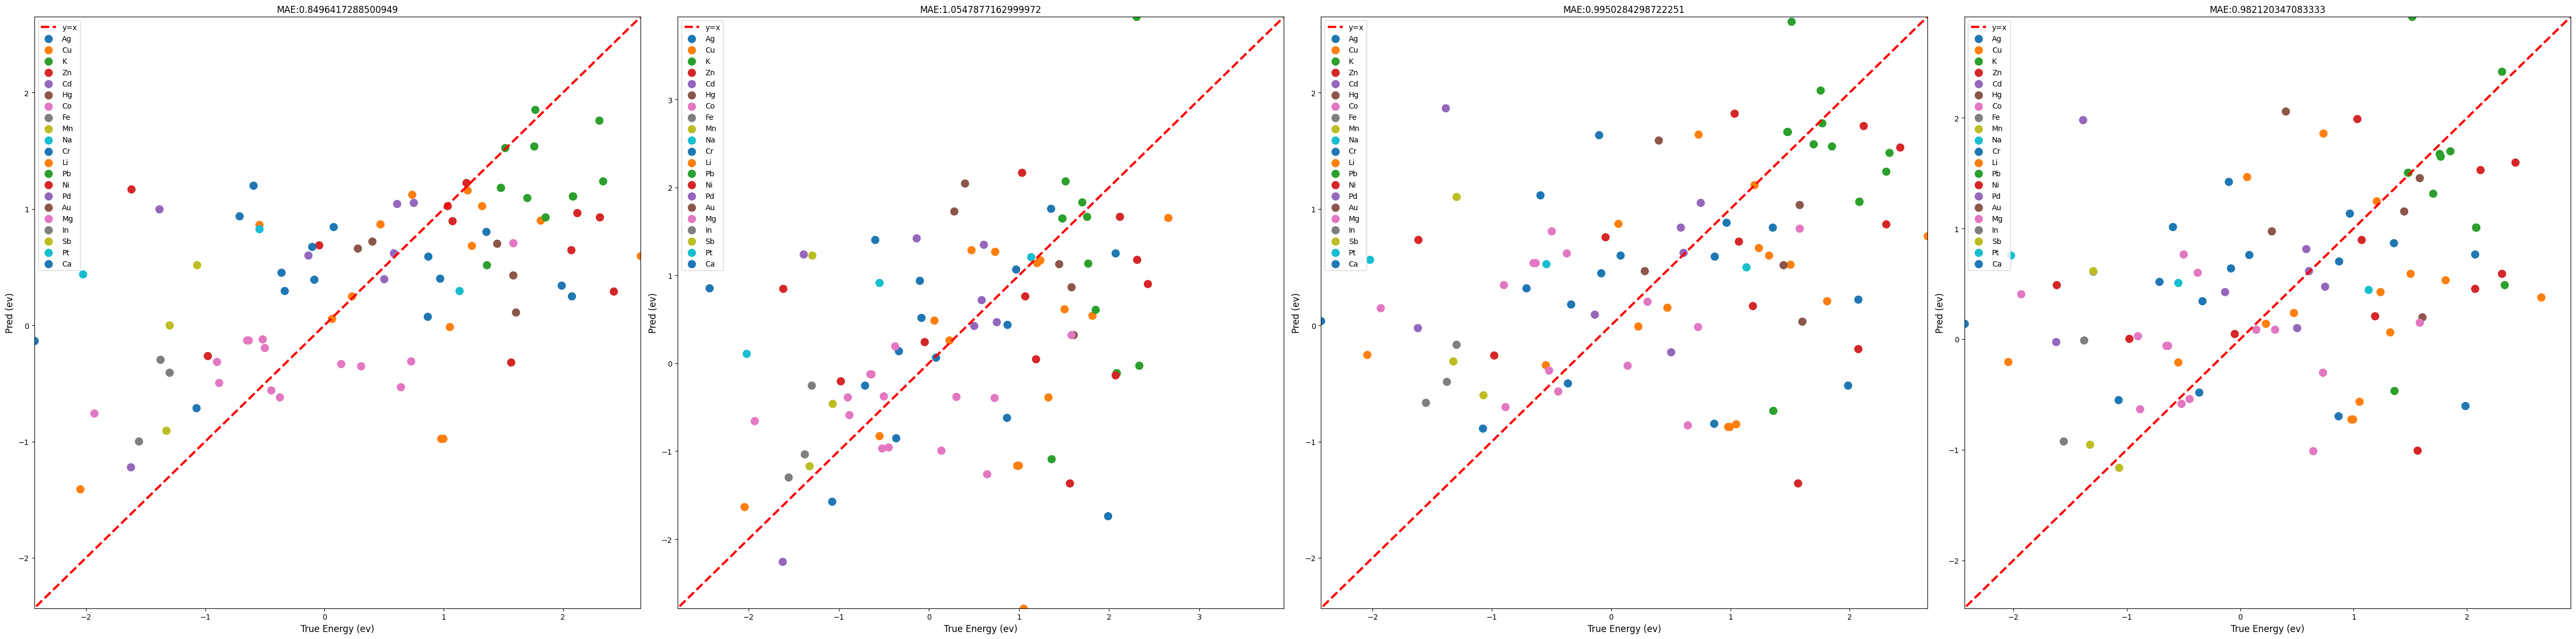

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_absolute_error
import colorlover as cl

# Create a figure with 4x4 subplots
props = ['oxo','h']
# columns = ["rf", "align-raw", "nn", "align-tl"]
columns = ["rf", "align-raw"]
n_rows = 1
n_cols = len(columns)


src_file_path = "./labels/qmofruns_2_suffled.csv"
df_source = pd.read_csv(src_file_path, index_col = 0)
df_source['ids'] = df_source['MOF'] +'.cif_'+ df_source['Site'].astype(str)


rf_racs = "./output/rf_pred_oxo_435_idx.csv"
nn_racs_only = "/scratch/yll6162/CrossPropertyTL/pred/mof_oxo_racs_pred.csv"
nn_racs_dband = "/scratch/yll6162/CrossPropertyTL/pred/mof_oxo_racs_dband_tl_pred.csv"
nn_racs_tot_e = "/scratch/yll6162/CrossPropertyTL/pred/mof_oxo_racs_tot_e_tl_pred.csv"

file_paths = [rf_racs, nn_racs_only, nn_racs_dband, nn_racs_tot_e]
# Example data for each subplot
fig, axes = plt.subplots(n_rows, len(file_paths), figsize=(12 * len(file_paths), 12))
prop = props[0]
for i, file_path in enumerate(file_paths):
    df = pd.read_csv(file_path, index_col = 0)

    df = df.merge(df_source, how='inner', left_on='ids_test', right_on = 'ids')

    preds = df["predictions"].values
    preds = np.clip(preds, None, 4)
    df['predictions'] = preds
    labels = df["labels"].values
    mae = mean_absolute_error(labels, preds)
    
    axes[i].plot([-100, 100], [-100, 100], '--r', label='y=x', linewidth=3)
    metals = df['Metal'].unique()
    axes[i].set_xlim(min(min(labels), min(preds)), max(max(labels), max(preds)))
    axes[i].set_ylim(min(min(labels), min(preds)), max(max(labels), max(preds)))
    axes[i].set_xlabel('True Energy (ev)', fontsize=12)
    axes[i].set_ylabel('Pred (ev)', fontsize=12)
    axes[i].set_title(f'MAE:{mae}', fontsize=12)
    colormap = cl.to_numeric(cl.scales['12']['qual']['Set3'])
    # colors = [cl.to_numeric(c) for c in colormap]
    for j, metal in enumerate(metals):
        labels = df[df["Metal"] == metal]['labels'].values
        preds = df[df["Metal"] == metal]['predictions'].values
        axes[i].scatter(labels, preds, s=100, marker='o', label = metal)


    axes[i].legend()
# for i in range(n_rows):
#     for j in range(n_cols):
#         row = rows[i]
#         col = columns[j]
#         axes[i, j].set_title(f'{row}_{col}')
#         filename = "_".join([col.split("_")[0], row, col.split("_")[1], prop]) + '.csv'
#         df = pd.read_csv(os.path.join("pred", filename))
#         preds = df["predictions"].values
#         labels = df["labels"].values
#         axes[i, j].scatter(labels, preds)
#         axes[i, j].plot([-100, 100], [-100, 100], '--r', label='y=x', linewidth=3)
#         axes[i, j].set_xlim(min(labels), max(labels))
#         axes[i, j].set_ylim(min(labels), max(labels))

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [34]:
import colorlover as cl
cl.scales['12']['qual']['Set3']

['rgb(141,211,199)',
 'rgb(255,255,179)',
 'rgb(190,186,218)',
 'rgb(251,128,114)',
 'rgb(128,177,211)',
 'rgb(253,180,98)',
 'rgb(179,222,105)',
 'rgb(252,205,229)',
 'rgb(217,217,217)',
 'rgb(188,128,189)',
 'rgb(204,235,197)',
 'rgb(255,237,111)']

In [18]:
src_file_path = "./labels/qmofruns_2_suffled.csv"
df_source = pd.read_csv(src_file_path, index_col = 0)
df_source

,index,MOF,E_MOF (eV),Site,Metal,Oxo Formation Energy,Hydrogen Affinity Energy,E_MOF_O (eV),E_MOF_OH (eV)
0,13298,qmof-0d451dd,-625.708244,2,Zn,1.134552,-1.282776,-629.313692,-633.986468
1,149,qmof-0e4f65c,-625.219444,0,Ag,-1.155837,0.051744,-631.115282,-634.453538
2,10847,qmof-56a6574,-511.492810,0,Bi,0.777348,-1.584848,-515.455462,-520.430310
3,1666,qmof-ad90d19,-818.046424,2,Cu,0.827687,-1.645269,-821.958737,-826.994007
4,3773,qmof-82ec815,-966.642275,0,Co,-1.737948,-1.277102,-973.120223,-977.787324
...,...,...,...,...,...,...,...,...,...
433,1690,qmof-0f56a20,-774.358323,2,Ag,-0.363261,-0.102235,-779.461585,-782.953820
434,20372,qmof-0dce90f,-913.083401,1,Cu,0.994080,-2.342019,-916.829321,-922.561340
435,6152,qmof-0f8fad1,-618.059781,0,Ca,-0.104489,-0.670565,-622.904270,-626.964835
436,18024,qmof-c2d0a95,-658.898302,0,Co,-0.447588,-1.398923,-664.085890,-668.874813


In [5]:
print(str(1e-6))

1e-06
